# Regresia logistică

[1] [Cross entrppy for dummies](https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735)

[2] [Understanding logistic regression](https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a)

[3] [Cross entropy log loss and intuition behind it](https://towardsdatascience.com/cross-entropy-log-loss-and-intuition-behind-it-364558dca514)

[4] [Cross entropy (a se vedea secţiunea "Relation with log-likelihood")](https://en.wikipedia.org/wiki/Cross_entropy)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import tableprint as tab
import pandas as pd

plt.rc('font', **{'size' : 18})

## 1. Introducere

Regresia liniară 'potriveşte' o funcţie liniară (polinomială) folosind un set de date $X$, pe tot domeniul $\mathbb{R}$, $linreg(x) : \mathbb{R}^m \rightarrow \mathbb{R}$. Regresia logistică are acelaşi domeniu, însă codomeniul este un set mult mai restrâns, şi anume $logreg(x) : \mathbb{R}^m \rightarrow [0, 1]$. Aceasta încearcă să prezică probabilitatea ca elementul $x \in X$ să facă parte dintr-o clasă (şi atunci probabilitatea este 1).

Această probabilitate o notăm cu $P(y=1|x,\theta)$, şi o interpretăm ca fiind probabilitatea asociată răspunsului $x^T \theta$ calculat de regresia clasică, în condiţiile în care cunoaştem feature-urile $X$ şi parametrii $\theta$ ai modelului.

Ideea este că pentru fiecare intrare $x$, modelul regresiei logistice asociază o probabilitate. Vom arăta cum alegem funcţia care calculează probabilitatea folosind răspunsul regresiei liniare $x^T \theta$.

Pornim de la o funcţie care are ca parametru o probabilitate şi care mapează intervalul $(0,1)$ în toată axa reală $\mathbb{R}$. Observăm cum funcţia $f_1(p) = \frac{p}{1-p}$ mapează probabilitatea în $\mathbb{R}^+$, iar dacă aplicăm logaritmul, funcţia $f_2(p) = log\left(\frac{p}{1-p}\right)$ mapează intervalul $(0, 1)$ în toată axa reală $\mathbb{R}$:

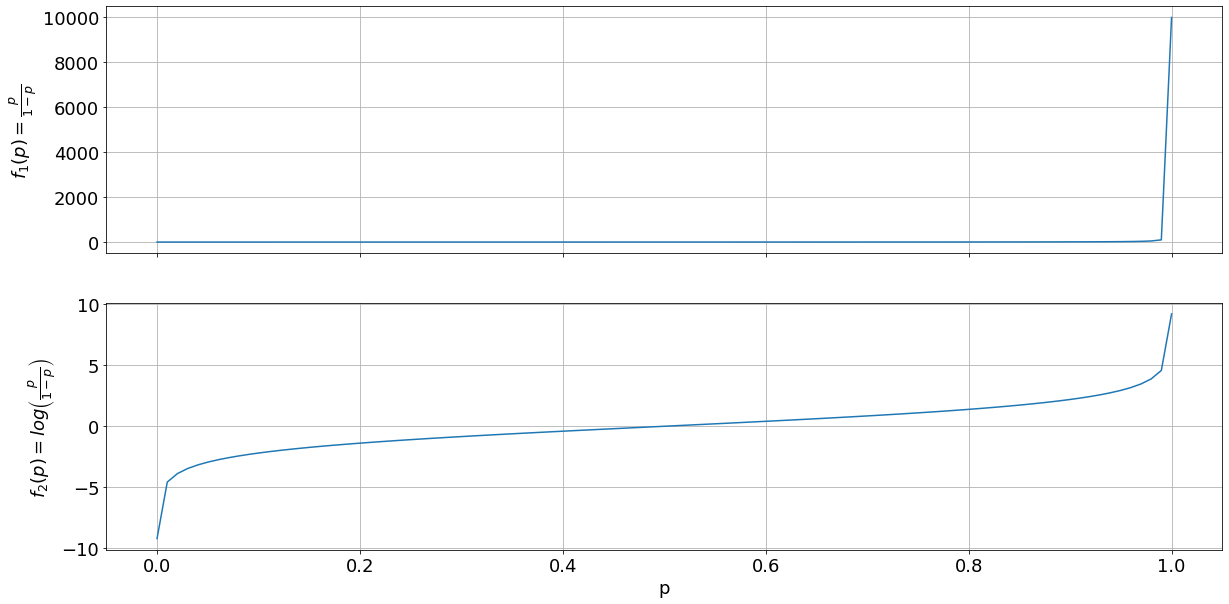

In [4]:
f1 = lambda x: x / (1 - x)
f2 = lambda x: np.log(x / (1 - x))
x = np.linspace(1e-4, 1-1e-4, 100)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, f1(x)) ; ax[1].plot(x, f2(x))
ax[0].set_ylabel(r'$f_1(p) = \frac{p}{1-p}$') ; ax[0].grid()
ax[1].set_xlabel('p') ; ax[1].set_ylabel(r'$f_2(p) = log\left(\frac{p}{1-p}\right)$') ; ax[1].grid()
plt.show()

Observaţi că dacă răspunsul dat de regresie este 0 ($f_2(p) = 0$), probabilitatea asociată este 0.5. Ne interesează ca răspunsul calculat de regresie (care poate fi orice valoare de pe axa reală) să fie egal cu această funcţie de probabilitate:

$$h_{\theta}(x) = x^T \theta = log\left(\frac{p}{1-p}\right)$$

Mai departe, prin câteva transformări algebrice, putem arăta că:

$$\hat{y} = P(y=1|x, \theta) = p = \frac{1}{1 + e^{-h_{\theta}(x)}}$$

Avem astfel o funcţie care mapează $x$ şi parametrii modelului $\theta$ într-o probabilitate. Funcţia este denumită funcţie logistică.

În realitate, avem setul de date $X$ şi asociat fiecărui $x_i$, $i=1 \dots m$, o valoare binară $y_i \in \{0, 1\}$. De fapt, setul de date $X$ este caracterizat de o distribuţie de probabilitate foarte simplă, distribuţie în care probabilităţile pot lua doar valorile 0 şi 1. Dacă am pune valorile $x_i$ pe abscisă şi valorile $y_i$ pe ordonată, graficul distribuţiei ar fi foarte accidentat - în fond, y ia doar două valori.

Am vrea ca modelul nostru caracterizat de coeficienţii $\theta$ să se 'potrivească' cât mai bine peste această distribuţie dată iniţial - probabil peisajul funcţiei de distribuţie a modelului nu mai este atât de rugos, ci mai neted (continuu, vălurit). Bineînteles acest exemplu este unul exagerat, în realitate spaţiul de intrare $X$ este unul $m$ dimensional, nu 1-dimensional cum am presupus aici ca să ne imaginăm reprezentarea distribuţiilor de probabilitate.

Pentru ca să putem compara însă 'cât de bine' se potriveşte distribuţia modelului pe care îl învăţăm cu distribuţia iniţială, avem nevoie de o măsură a acestor distribuţii. Pentru aceasta vom introduce noţiunea de entropie ca măsură a informaţiei.

## 2. Informaţia şi entropia

Noţiunea de informaţie asociată unei probabilităţi a fost introdusă de Claude Shannon (1948) în lucrarea sa de Teoria Informaţiei pentru a măsura gradul de surpriză asociat cu producerea unui eveniment - informaţia obţinută. 

De exemplu, să luăm o monedă trucată. Aceasta cade întotdeauna cu capul în sus (Head), indiferent cum o aruncăm. Deci probabilitatea să obţinem Head pentru această monedă trucată este $P_{trucata}(H) = 1$. Incertitudinea este 0, ştim sigur că moneda iese întotdeauna Head. Informaţia obţinută este 0 (nu sunt surprize).

Dacă în urma unei aruncări moneda noastră trucată pică pe cealaltă parte (stemă, Tail), factorul surpriză este imens, şi informaţia furnizată este deosebită, deoarece anterior ştiam că nu poate să iasă - $P_{trucata}(T) = 0$.

Putem astfel să definim __cantitatea de informaţie__ furnizată la producerea unui eveniment $x$ care are asociată o anumită probabilitate ca fiind:

$$I(P(x)) = - \log P(x)$$

Ca fapt divers, dacă baza logaritmului este 2, informaţia se măsoară în biţi. Noi vom folosi în general logaritmul natural (se derivează mai frumos).

Observaţi vă rog că $I(P_{trucata}(H) = 1) = - \log 1 = 0$, producerea evenimentului sigur nu oferă nici o informaţie, pe când $I(P_{trucata}(T) = 0) = - \log 0 = \infty$, producerea evenimentului imposibil oferă extrem multă informaţie.

Putem oare să deosebim între o monedă falsă şi una normală, folosind probabilităţile asociate evenimentelor H şi T? Dacă ne uităm la suficient de multe evenimente, adică la comportamentul mediu al celor două monede, ar trebui să putem.

Definim pentru aceasta informaţia medie, sau __entropia__ asociată unei variabile care pentru fiecare eveniment $x$ are asociată o probabilitate $p(x)$, ca fiind valoarea aşteptată a informaţiei. Valoarea medie o calculăm ca o medie ponderată. Entropia asociată distribuţiei de probabilitate $P$ (în care fiecare din evenimentele $x_i$ are asociată o probabilitate $p(x_i)$, este:

$$E(P) = -\sum_i p(x_i) \log p(x_i)$$

În cazul simplu în care sunt doar două evenimente $x_1 = Head$ şi $x_2 = Tail$, avem:

$$E(P) = - p(H) \log p(H) - p(T) \log p(T)$$

Pentru moneda trucată, avem:

$$\begin{align}
E(P_{trucata}) & = - p_{trucata}(H) \log p_{trucata}(H) - p_{trucata}(T) \log p_{trucata}(T) \\
& = -1 \log 1 - 0 \log 0 \\
& = 0
\end{align}$$

Pentru o monedă normală, probabilitatea de a cădea fie Head fie Tail este egală (0.5):

$$\begin{align}
E(P_{normala}) & = - p_{normala}(H) \log p_{normala}(H) - p_{normala}(T) \log p_{normala}(T) \\
& = -0.5 \log 0.5 - 0.5 \log 0.5 \\
& = - \log 0.5 \\
& = -(\log 1 - \log 2) \\
& = 1\end{align}$$

Cantitatea medie de informaţie obţinută pentru moneda trucată este 0 biţi, pe când cantitatea medie de informaţie obţinută pentru moneda normală este de 1 bit. Este un alt fel de a spune că moneda trucată nu ne dă nici o informaţie, se comportă în medie conform aşteptărilor, pe când o monedă normală este interesantă, oferă informaţii noi.

Formal, entropia este informaţia medie per eveniment:

$$E(P) = \mathbb{E}_{x \sim P}[-\log P(x)] = -\sum_i p(x_i) \log p(x_i)$$

Observaţi că informaţia $-\log P(x_i)$ este asociată evenimentelor $x_i$, aceleaşi din distribuţie de probabilitate $P$ ce este descrisă de probabilităţile $p(x_i)$.

Ce se întâmplă însă când calculăm informaţia medie pentru evenimentele dintr-o distribuţie, dar folosind probabilităţi dintr-o altă distribuţie? Obţinem un instrument prin care putem compara cele două distribuţii de probabilitate. Astfel, __cross-entropia__ este definită ca informaţia medie pentru distribuţia Q atunci când se observă o distribuţie cunoscută P:

$$E(P, Q) = \mathbb{E}_{x \sim P}[-\log Q(x)] = -\sum_i p(x_i) \log q(x_i)$$

Asta este foarte interesant, pentru că dacă avem definiă cantitatea de informaţie pentru fiecare eveniment pe distribuţia Q clasificatorului pe care voim să-l antrenăm, putem să calculăm informaţia medie pentru realitatea distribuţiei P.

Dacă cele două distribuţii sunt apropiate, cross-entropia este minimă. Algoritmul regresiei logistice se bazează tocmai pe minimizarea acestei cantităţi.

Pentru cazul regresiei logistice, distribuţiile de probabilitate sunt simple - există doar două clase. Putem să extrapolăm exemplul cu moneda şi să ne gândim că regresia logistică binară este un fel de monedă (în fond şi regresia logistică ţinteşte doar două valori, 0 şi 1).

Clasa P este evidenţa, pe care am notat-o cu $y_i \in \{0, 1\}$, iar valoarea produsă de regresie am notat-o cu $\hat{y} \in [0, 1]$. Cross-entropia binară va fi atunci exprimată doar pentru cele două valori:

$$E(Y, \hat{Y}) = -y \log \hat{y} - (1-y) \log (1-\hat{y})$$

## 3. Regresia logistică binomială

Funcţia de cost pentru regresia logistică este dată de cross-entropia binară, scrisă sub formă vectorială astfel:

$$J(\theta) = \frac{1}{m} \mathbb{1}_m^T \left\{ - Y \odot \ln[h(X\theta)] - (\mathbb{1}_m-Y) \odot \ln[1-h(X\theta)] \right\}$$

Avem nevoie de câteva expresii pentru calculul ce urmează.

Prima dată observăm derivata funcţiei sigmoide $h(u)$:

$$\begin{align}
h'(u) &= \left( \frac{1}{1 + e^{-u}} \right)'\\
&= - \frac{(1+e^{-u})'}{(1+e^{-u})^2} \\
&= \frac{e^{-u}}{(1+e^{-u})^2} \\
&= \frac{1+e^{-u}-1}{(1+e^{-u})^2} \\
&= \frac{1}{1+e^{-u}} - \frac{1}{(1+e^{-u})^2} \\
&= \frac{1}{1+e^{-u}} \left( 1 - \frac{1}{1+e^{-u}} \right) \\
&= h(u) [1-h(u)] \\
\end{align}$$

Mai departe, calculăm derivata funcţiei de cost, folosind notaţia $u = X\theta$ (am folosit produsul element-cu-element, cu excepţia lui $X \theta$, care este o înmulţire de matrici):

$$\begin{align}
\nabla_{\theta} J(\theta) &= \nabla_{\theta} \left\{-Y \ln[h(u)] - (1-Y) \ln[1-h(u)] \right\} \\
&= -\frac{Y}{h(u)}h'(u) X + \frac{1-Y}{1-h(u)}h'(u) X \\
&= \left\{ -\frac{Y}{h(u)}h(u)[1-h(u)] + \frac{1-Y}{1-h(u)}h(u)[1-h(u)] \right\} X \\
&= \left\{ -Y[1-h(u)] + (1-Y)h(u) \right\} X \\
&= \left[ -Y + Y h(u) + h(u) - Y h(u) \right] X \\
&= \left[ h(u) - Y \right] X \\
&= \left[ h(X \theta) - Y \right] X
\end{align}$$

### 3.1 Încărcarea setului de date

In [5]:
train_set = pd.read_csv('mnist_train.csv').values
test_set = pd.read_csv('mnist_test.csv').values

In [6]:
# train_set si test_set sunt matrici care contin pe prima coloana clasa (o cifra de la 0 la 9),
#  iar imaginea este pastrata incepand de pe coloana 1 pana la terminare.
# Decupati in train_x doar imaginile iar in train_y doar clasa,
#  si faceti acelasi lucru si pentru test_x si test_y
train_x, train_y = ...
test_x, test_y = ...

assert train_x.shape == (59999, 784)
assert train_y.shape == (59999,)
assert test_x.shape == (9999, 784)
assert test_y.shape == (9999,)

Să vizualizăm setul de date. Vom observa primele 16 linii din setul de antrenare:

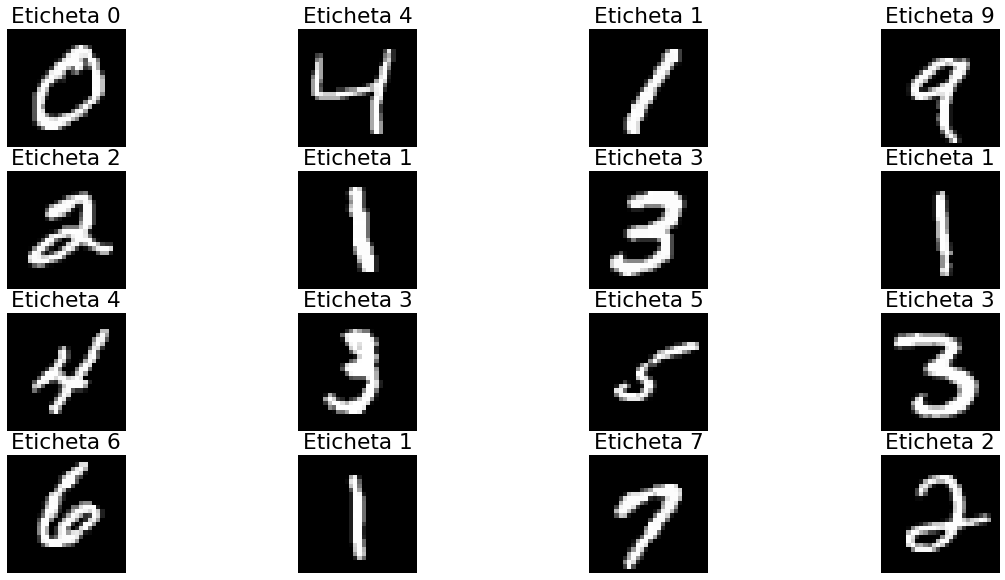

In [7]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16], train_y[:16])

Pentru regresia binomială, ne interesează să clasificăm deocamdată doar imaginile corespunzătoare a două clase, pentru cifrele '0' şi '1'. Vom defini seturile care 'decupează' doar aceste două clase din seturile date:

In [8]:
# Filtrati din seturile mari doar acele sample-uri corespunzatoare cifrelor 0 si 1
train_x_bin, train_y_bin = ...

test_x_bin, test_y_bin = ...

assert train_x_bin.shape == (12665, 784)
assert train_y_bin.shape == (12665, 1)
assert test_x_bin.shape == (2115, 784)
assert test_y_bin.shape == (2115, 1)

 La fel ca si la regresia liniară, prima coloană trebuie să fie formată doar din cifra 1:

In [9]:
def add_ones_column(x):
    """
    Adds a column of ones to x
    """
    # ...
    return ...

train_x_bin_ext = add_ones_column(train_x_bin)
test_x_bin_ext = add_ones_column(test_x_bin)

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

Feature-urile trebuiesc normalizate, valoarea maximă fiind 255. Normalizarea urmăreşte ca toate featurile rezultate să fie în intervalul \[0, 1\], deci vom împărţi la valoarea maximă.

In [10]:
def normalize(x):
    """
    Normalization means division by 255
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
    
    Returns:
        matricea cu valorile normalizate in in [0, 1], dimensiune m x n
    """
    return ...

train_x_bin_ext = add_ones_column(normalize(train_x_bin))
test_x_bin_ext = add_ones_column(normalize(test_x_bin))

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

Calculăm funcţia sigmoidă, $sigmoid(z) = \frac{1}{1 + e^{-z}}$ respectiv $h(x, \theta) = sigmoid \left( \frac{1}{1 + e^{-X  \theta}} \right)$:

In [11]:
def sigmoid(z):
    return ...

assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x, theta):
    return ...

assert np.abs(h(np.array([1., 1., 1., 0]), np.array([1., 0., 1., 1.])) - 0.880797) < 1e-6

Calculăm funcţia de cost cu regularizare de data aceasta (atenţie, coeficientul $\theta_0$ nu se regularizează):

$$J(\theta) = \frac{1}{m} \mathbb{1}_m^T \left\{ - Y \odot \ln[h(X \theta)] - (\mathbb{1}_m-Y) \odot \ln[1-h(X \theta)] \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1} \|\theta_i\|^2$$

Am folosit aici notaţia $\odot$, ce specifică produsul Hadamard, element cu element. Pentru a realiza înmulţirea dintre matricea $X$ de dimensiune $(m, n)$ şi vectorul $\theta$ de dimensiune $(n, 1)$, produsul de matrici $X \cdot \theta$ este considerat implicit.

In [12]:
def cost(x, y, theta, lmbda):
    """
    Cost function includes also regularization
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n
        
    Returns:
        costul, ca scalar
    """
    return ...

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
assert np.abs(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2) - 1.24126) < 1e-6

Calculăm gradientul, folosind expresia determinată anterior, şi ţinând seama de termenul de regularizare:

$$\nabla_{\theta} J(X, Y, \theta) = \frac{1}{m} \mathbb{1}_m^T \left[ h(X \theta) - Y\right] + \lambda \sum_{i=1}^{n-1} |\theta_i|$$

In [13]:
def deltas(x, y, theta, lmbda):
    """
    Computation of gradient with regularization term
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n
        lmbda: coeficientul de regularizare
        
    Returns:
        gradientul, vector de n elemente
    """
    return ...

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
res = deltas(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)
assert res.shape == (785, 1)

Algoritmul de antrenare va stoca costul asociat fiecărei epoci într-o listă:

In [14]:
def compute_accuracy(x_set, y_set, theta):
    # ...
    return 100.0 * ...

In [17]:
# Set learning rate
eta = 0.2

# Set regularization coefficient
lmbda = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n = np.shape(train_x_bin_ext)[1]
theta = np.random.randn(n).reshape(n, 1)

# Do the training
epochs = 20
values = []
accurracies = []
for i in range(epochs):
    theta -= eta * deltas(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc = compute_accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print("last cost: %g" % values[-1])

last cost: 0.124159


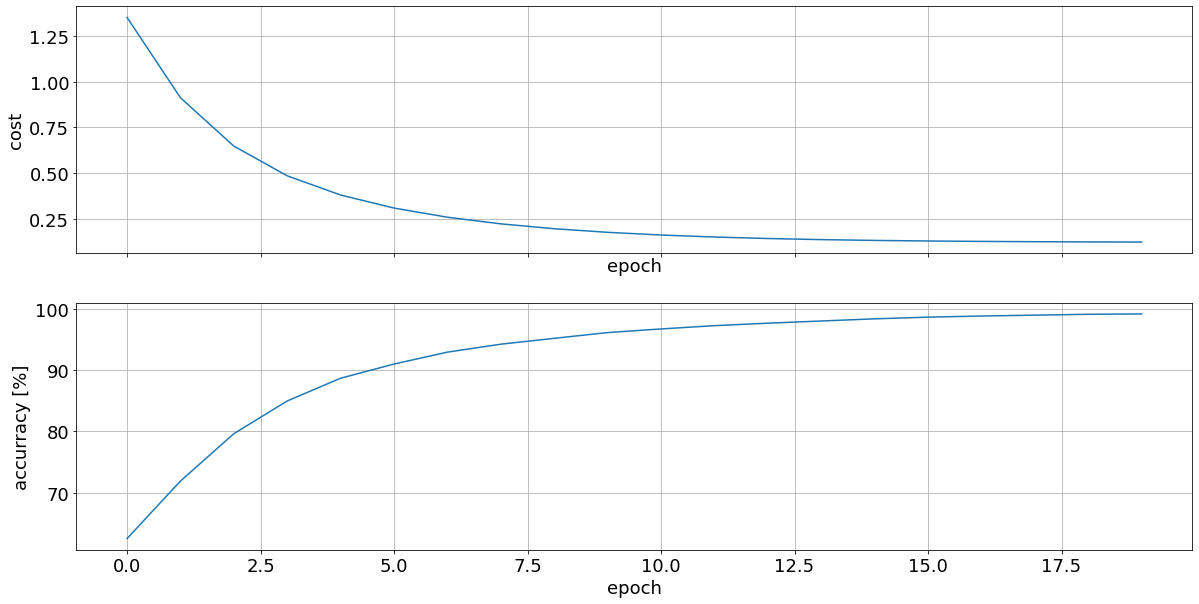

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [19]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = ...
print("accuracy: %2.2f%% for %d patterns" % (...))

# Calculam confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
pred = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp = np.sum(np.logical_and(pred == 1, test_y_bin == 1))
tn = np.sum(np.logical_and(pred == 0, test_y_bin == 0))
fp = np.sum(np.logical_and(pred == 1, test_y_bin == 0))
fn = np.sum(np.logical_and(pred == 0, test_y_bin == 1))

headers = ['Confusion Matrix', 'pred: 0', 'pred: 1', 'pred: all'] 
table = [
    ['actual: 0', tn, fp, tn + fp],
    ['actual: 1', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

accuracy: 99.67% for 2115 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          pred: 0 │          pred: 1 │        pred: all │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        actual: 0 │              975 │                5 │              980 │
│        actual: 1 │                2 │             1133 │             1135 │
│      actual: all │              977 │             1138 │             2115 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## 4. Regresia logistică multinomială

In [20]:
# classes
k = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext = add_ones_column(normalize(train_x))
test_x_all_ext = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (59999, 785)
assert test_x_all_ext.shape == (9999, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

In [21]:
def one_hot(val, classes):
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    # ..
    return ...

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (59999, 10)
assert test_y_all.shape == (9999, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Produsul $X \theta$ între matricea X de dimensiune (m, n) şi $\theta$ de dimensiune (n, k) va avea dimensiunea (m, k):

In [22]:
def prod(x, theta):
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    return ...

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

Funcţia $softmax()$ va avea aceleaşi dimensiuni (m, k) şi trebuie să dea pe fiecare coloană suma 1. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea (m, 1) (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [23]:
def softmax(x, theta):
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """

    # ...
    return ...

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel:

$$J(X, Y, \theta, \lambda) = \frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1} \|\theta_i\|^2$$

In [24]:
def cost(x, y, theta, lmbda):
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    return ...

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima coloană este zero.

In [25]:
def deltas(x, y, theta, lmbda):
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    # ...
    return ...

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
grad = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)
assert grad.shape == (n, k)
assert (grad.sum() + 6.0286086) < 1e-6

In [26]:
def calculate_accurracy(set_x, set_y, theta):
    # ...
    return 100.0 * ...

In [33]:
# numarul de clase
k = 10

lmbda, alpha = 0.05, 0.65
m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)

epochs = 300
values = []
accurracies = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda)
    if (i % 10 == 0):
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  194.5528550437345
epoch:  10 cost:  93.81863374749436
epoch:  20 cost:  49.13055686165839
epoch:  30 cost:  27.42488074595834
epoch:  40 cost:  16.20668516652925
epoch:  50 cost:  10.102156806770875
epoch:  60 cost:  6.625541471995606
epoch:  70 cost:  4.561877084206647
epoch:  80 cost:  3.289199509105865
epoch:  90 cost:  2.4759135293600902
epoch:  100 cost:  1.9386176889271702
epoch:  110 cost:  1.5723950488109997
epoch:  120 cost:  1.3153287550439503
epoch:  130 cost:  1.129812147686424
epoch:  140 cost:  0.9923883846410227
epoch:  150 cost:  0.8880618681299075
epoch:  160 cost:  0.8070247680570986
epoch:  170 cost:  0.7427246081027247
epoch:  180 cost:  0.6906961045857418
epoch:  190 cost:  0.6478392273606401
epoch:  200 cost:  0.6119637570842354
epoch:  210 cost:  0.5814964005736104
epoch:  220 cost:  0.5552890416895622
epoch:  230 cost:  0.5324910873838979
epoch:  240 cost:  0.5124631437919052
epoch:  250 cost:  0.49471777917866416
epoch:  260 cost:  0.4788783117

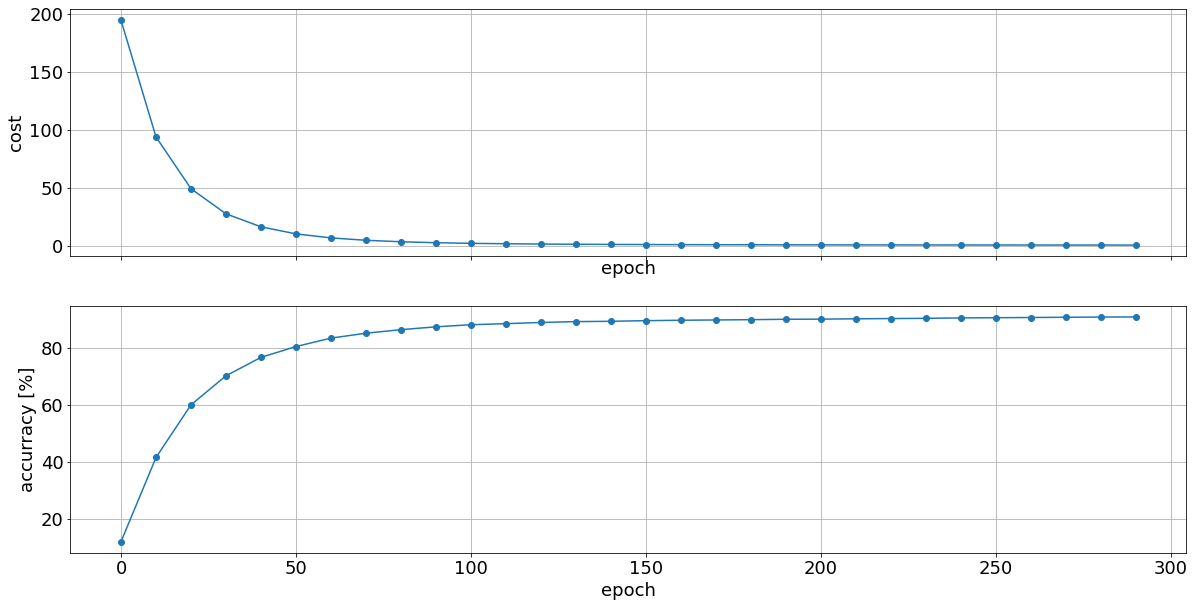

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [35]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = ..
actual = ..
equalities = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % ( ... ))

Test accuracy: 90.82%


In [36]:
# Calculam vectorii predictiilor precum si vectorul realitatii
pred = ...
actual = ...

# Confusion matrix va avea la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei
# au fost prezise ca fiind facand parte din clasa data de numarul coloanei
conf_matrix = ...
# ...
    
assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

    
headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table = []
for i in range(k):
    table.append([f'act: {i}'] + ...)
table.append(
    ['all p'] + ...
)

tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    962 │      0 │      2 │      1 │      1 │      2 │      8 │      1 │      3 │      0 │    980 │
│ act: 1 │      0 │   1104 │      2 │      4 │      1 │      2 │      4 │      2 │     16 │      0 │   1135 │
│ act: 2 │     12 │     12 │    891 │     15 │     15 │      2 │     15 │     18 │     42 │     10 │   1032 │
│ act: 3 │      6 │      2 │     18 │    904 │      1 │     32 │      3 │     15 │     19 │     10 │   1010 │
│ act: 4 │      1 │      4 │      4 │      0 │    910 │      1 │     11 │      1 │      8 │     42 │    982 │
│ act: 5 │     14 │      4 │      3 │     42 │     14 │    747 │     16 │     11 │     32 │      9 │    892 │
│ act: 6 │